# Create and run a local RAG pipeline 

The goal of this notebook is to build a RAG (Retrieval Augmented Generation) pipeline from scratch and have it run on a local GPU.

Specifically, we'd like to be able to open a PDF file, ask questions (queries) of it and have them answered by a Large Language Model (LLM).

There are frameworks that replicate this kind of workflow, including [LlamaIndex](https://www.llamaindex.ai/) and [LangChain](https://www.langchain.com/), however, the goal of building from scratch is to be able to inspect and customize all the parts.

## Import PDF Document




In [2]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Download PDF file
import os
import requests

# Get PDF document
pdf_path = "Learning_Python.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File Learning_Python.pdf exists.


In [3]:
# Requires !pip install PyMuPDF, see: https://github.com/pymupdf/pymupdf
import fitz # (pymupdf, found this is better than pypdf for our use case, note: licence is AGPL-3.0, keep that in mind if you want to use any code commercially)
from tqdm.auto import tqdm # for progress bars, requires !pip install tqdm 

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip() # note: this might be different for each doc (best to experiment)

    # Other potential text formatting functions can go here
    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 41,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 18,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 4.5,
  'text': 'www.it-ebooks.info'},
 {'page_number': -40,
  'page_char_count': 18,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 4.5,
  'text': 'www.it-ebooks.info'}]

In [4]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 792,
  'page_char_count': 18,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 4.5,
  'text': 'www.it-ebooks.info'},
 {'page_number': 1301,
  'page_char_count': 2294,
  'page_word_count': 590,
  'page_sentence_count_raw': 5,
  'page_token_count': 573.5,
  'text': 'As mentioned earlier, this happens because Python passes the implied subject instance to self when a method name is bound to a simple function only; when it is an instance of a callable class, that class’s instance is passed instead. Technically, Python makes a bound method object containing the subject instance only when the method is a simple function, not when it is a callable instance of another class. Using nested functions to decorate methods If you want your function decorators to work on both simple functions and class-level methods, the most straightforward solution lies in using one of the other state retention solutions described earlier—code your function decorator as 

In [5]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,18,1,1,4.5,www.it-ebooks.info
1,-40,18,1,1,4.5,www.it-ebooks.info
2,-39,116,18,1,29.0,FIFTH EDITION Learning Python Mark Lutz Beijin...
3,-38,1718,235,15,429.5,"Learning Python, Fifth Edition by Mark Lutz Co..."
4,-37,44,7,3,11.0,To Vera. You are my life. www.it-ebooks.info


In [6]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1594.00,1594.00,1594.00,1594.00,1594.00
mean,755.50,2279.04,432.64,13.15,569.76
std,460.29,590.69,126.47,12.22,147.67
min,-41.00,18.00,1.00,1.00,4.50
25%,357.25,2056.00,380.00,7.00,514.00
50%,755.50,2391.00,447.50,12.00,597.75
75%,1153.75,2641.00,501.00,17.00,660.25
max,1552.00,3397.00,1005.00,155.00,849.25


In [7]:
from spacy.lang.en import English # see https://spacy.io/usage for install instructions

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/ 
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

In [8]:

for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    
    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    
    # Count the sentences 
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1594 [00:00<?, ?it/s]

In [9]:
# Inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 444,
  'page_char_count': 2247,
  'page_word_count': 428,
  'page_sentence_count_raw': 11,
  'page_token_count': 561.75,
  'text': ">>> >>> A, B = zip(*zip(X, Y))             # Unzip a zip! >>> A (1, 2) >>> B (3, 4) Still other tools in Python, such as the range built-in and dictionary view objects, return iterables instead of processing them. To see how these have been absorbed into the iteration protocol in Python 3.X as well, we need to move on to the next section. New Iterables in Python 3.X One of the fundamental distinctions of Python 3.X is its stronger emphasis on iterators than 2.X. This, along with its Unicode model and mandated new-style classes, is one of 3.X’s most sweeping changes. Specifically, in addition to the iterators associated with built-in types such as files and dictionaries, the dictionary methods keys, values, and items return iterable objects in Python 3.X, as do the built-in functions range, map, zip, and filter. As shown in the prior sectio

In [11]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1594.00,1594.00,1594.00,1594.00,1594.00,1594.00
mean,755.50,2279.04,432.64,13.15,569.76,11.98
std,460.29,590.69,126.47,12.22,147.67,6.70
min,-41.00,18.00,1.00,1.00,4.50,1.00
25%,357.25,2056.00,380.00,7.00,514.00,7.00
50%,755.50,2391.00,447.50,12.00,597.75,11.00
75%,1153.75,2641.00,501.00,17.00,660.25,16.00
max,1552.00,3397.00,1005.00,155.00,849.25,44.00


In [12]:

# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10 

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list, 
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1594 [00:00<?, ?it/s]

In [13]:

# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
random.sample(pages_and_texts, k=1)

[{'page_number': 958,
  'page_char_count': 2697,
  'page_word_count': 450,
  'page_sentence_count_raw': 16,
  'page_token_count': 674.25,
  'text': 'Methods Are Objects: Bound or Unbound Methods in general, and bound methods in particular, simplify the implementation of many design goals in Python. We met bound methods briefly while studying __call__ in Chapter 30. The full story, which we’ll flesh out here, turns out to be more general and flexible than you might expect. In Chapter 19, we learned how functions can be processed as normal objects. Methods are a kind of object too, and can be used generically in much the same way as other objects—they can be assigned to names, passed to functions, stored in data structures, and so on—and like simple functions, qualify as “first class” objects. Because a class’s methods can be accessed from an instance or a class, though, they actually come in two flavors in Python: Unbound (class) method objects: no self Accessing a function attribute of

In [14]:

# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1594.00,1594.00,1594.00,1594.00,1594.00,1594.00,1594.00
mean,755.50,2279.04,432.64,13.15,569.76,11.98,1.66
std,460.29,590.69,126.47,12.22,147.67,6.70,0.69
min,-41.00,18.00,1.00,1.00,4.50,1.00,1.00
25%,357.25,2056.00,380.00,7.00,514.00,7.00,1.00
50%,755.50,2391.00,447.50,12.00,597.75,11.00,2.00
75%,1153.75,2641.00,501.00,17.00,660.25,16.00,2.00
max,1552.00,3397.00,1005.00,155.00,849.25,44.00,5.00


In [15]:

import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo 
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters
        
        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/1594 [00:00<?, ?it/s]

2648

In [17]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 1473,
  'sentence_chunk': 'the upcoming Python 3.0 release were incorporated where appropriate. Here are some of the major language topics for which new or expanded coverage was provided (chap- ter numbers here have been updated to reflect this fifth edition): • The new B if A else C conditional expression (Chapter 12, Chapter 19) • with/as context managers (Chapter 34) • try/except/finally unification (Chapter 34) • Relative import syntax (Chapter 24) • Generator expressions (Chapter 20) • New generator function features (Chapter 20) • Function decorators (Chapter 32, Chapter 39) • The set object type (Chapter 5) • New built-in functions: sorted, sum, any, all, enumerate (Chapter 13 and Chap- ter 14) • The decimal fixed-precision object type (Chapter 5) • Files, list comprehensions, and iterators (Chapter 14 and Chapter 20) • New development tools: Eclipse, distutils, unittest and doctest, IDLE enhance- ments, Shed Skin, and so on (Chapter 2 and Chapter 36) Smaller la

In [18]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,2648.00,2648.00,2648.00,2648.00
mean,722.58,1349.26,238.19,337.31
std,457.19,704.02,132.71,176.01
min,-41.00,18.00,1.00,4.50
25%,325.00,793.25,135.00,198.31
50%,710.50,1388.00,235.00,347.00
75%,1112.00,1925.25,343.00,481.31
max,1552.00,2895.00,644.00,723.75


In [19]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 13.0 | Text: Anonymous Functions: lambda | 573 www.it-ebooks.info
Chunk token count: 4.5 | Text: www.it-ebooks.info
Chunk token count: 4.5 | Text: www.it-ebooks.info
Chunk token count: 17.25 | Text: 1440 | Appendix B: The Python 3.3 Windows Launcher www.it-ebooks.info
Chunk token count: 12.25 | Text: Test Your Knowledge: Quiz | 85 www.it-ebooks.info


In [20]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -38,
  'sentence_chunk': 'Learning Python, Fifth Edition by Mark Lutz Copyright © 2013 Mark Lutz. All rights reserved. Printed in the United States of America. Published by O’Reilly Media, Inc., 1005 Gravenstein Highway North, Sebastopol, CA 95472. O’Reilly books may be purchased for educational, business, or sales promotional use. Online editions are also available for most titles (http://my.safaribooksonline.com). For more information, contact our corporate/institutional sales department: 800-998-9938 or corporate@oreilly.com. Editor: Rachel Roumeliotis Production Editor: Christopher Hearse Copyeditor: Rachel Monaghan Proofreader: Julie Van Keuren Indexer: Lucie Haskins Cover Designer: Randy Comer Interior Designer: David Futato Illustrator: Rebecca Demarest June 2013: Fifth Edition. Revision History for the Fifth Edition: 2013-06-07 First release See http://oreilly.com/catalog/errata.csp?isbn=9781449355739 for release details. Nutshell Handbook, the Nutshell Handboo

In [21]:

# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device="cpu") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07982697e-02  3.03164832e-02 -2.01217849e-02  6.86484650e-02
 -2.55256221e-02 -8.47686455e-03 -2.07225574e-04 -6.32377118e-02
  2.81606894e-02 -3.33353989e-02  3.02633960e-02  5.30721806e-02
 -5.03527038e-02  2.62288321e-02  3.33313718e-02 -4.51577231e-02
  3.63044813e-02 -1.37122418e-03 -1.20171458e-02  1.14947259e-02
  5.04510924e-02  4.70856987e-02  2.11913940e-02  5.14606535e-02
 -2.03746483e-02 -3.58889401e-02 -6.67763175e-04 -2.94393823e-02
  4.95859198e-02 -1.05639677e-02 -1.52014112e-02 -1.31758570e-03
  4.48197424e-02  1.56023465e-02  8.60379430e-07 -1.21392624e-03
 -2.37978697e-02 -9.09368275e-04  7.34484056e-03 -2.53933994e-03
  5.23370504e-02 -4.68043424e-02  1.66214760e-02  4.71579395e-02
 -4.15599644e-02  9.01976076e-04  3.60277519e-02  3.42214219e-02
  9.68227163e-02  5.94829023e-02 -1.64984372e-02 -3.51249315e-02
  5.92516130e-03 -7.07903586e-04 -2.4103

In [22]:
single_sentence = "Yo! How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: Yo! How cool are embeddings?
Embedding:
[-1.97448079e-02 -4.51075705e-03 -4.98487940e-03  6.55444935e-02
 -9.87675507e-03  2.72835791e-02  3.66426073e-02 -3.30219418e-03
  8.50080699e-03  8.24952591e-03 -2.28497498e-02  4.02430184e-02
 -5.75200468e-02  6.33692369e-02  4.43207286e-02 -4.49506305e-02
  1.25284856e-02 -2.52011903e-02 -3.55292968e-02  1.29559524e-02
  8.67019407e-03 -1.92917567e-02  3.55633814e-03  1.89505871e-02
 -1.47128217e-02 -9.39846132e-03  7.64174713e-03  9.62186605e-03
 -5.98921767e-03 -3.90168838e-02 -5.47824688e-02 -5.67455497e-03
  1.11644398e-02  4.08067666e-02  1.76319099e-06  9.15302895e-03
 -8.77257995e-03  2.39382777e-02 -2.32784543e-02  8.04999843e-02
  3.19177285e-02  5.12598269e-03 -1.47708189e-02 -1.62525009e-02
 -6.03213087e-02 -4.35689837e-02  4.51211371e-02 -1.79053824e-02
  2.63366513e-02 -3.47866826e-02 -8.89171939e-03 -5.47675304e-02
 -1.24372775e-02 -2.38606706e-02  8.33497122e-02  5.71241677e-02
  1.13328574e-02 -1.49595020e-02  9.2037

In [ ]:
%%time

# Uncomment to see how long it takes to create embeddings on CPU
# # Make sure the model is on the CPU
# embedding_model.to("cpu")

# # Embed each chunk one by one
# for item in tqdm(pages_and_chunks_over_min_token_len):
#     item["embedding"] = embedding_model.encode(item["sentence_chunk"])

In [23]:
%%time

# Send the model to the GPU
embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4090

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/2533 [00:00<?, ?it/s]

CPU times: user 2min 15s, sys: 385 ms, total: 2min 16s
Wall time: 29.1 s


In [24]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [25]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: user 36 s, sys: 350 ms, total: 36.4 s
Wall time: 29.7 s


tensor([[ 0.0072, -0.0228, -0.0250,  ...,  0.0372,  0.0371, -0.0255],
        [ 0.0671, -0.0713, -0.0420,  ..., -0.0247, -0.0203, -0.0046],
        [ 0.0347, -0.0052, -0.0341,  ...,  0.0356,  0.0503, -0.0269],
        ...,
        [ 0.0120, -0.0178, -0.0234,  ...,  0.0019,  0.0049, -0.0200],
        [ 0.0255, -0.0076, -0.0091,  ...,  0.0279,  0.0581, -0.0417],
        [ 0.0049,  0.0497,  0.0127,  ...,  0.0375,  0.0082, -0.0077]],
       device='cuda:0')

In [26]:

# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [27]:

# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-38,"Learning Python, Fifth Edition by Mark Lutz Co...",1270,166,317.5,[ 7.19811441e-03 -2.28243228e-02 -2.49604322e-...
1,-38,"Where those designations appear in this book, ...",446,68,111.5,[ 6.71424121e-02 -7.12570101e-02 -4.19863462e-...
2,-35,Table of Contents Preface . . . . . . . . . . ...,830,209,207.5,[ 3.47342417e-02 -5.15475310e-03 -3.40681002e-...
3,-35,16 It’s Object-Oriented and Functional 16 It’s...,222,38,55.5,[ 4.22786586e-02 -5.48424460e-02 1.46838880e-...
4,-34,How Does Python Stack Up to Language X?21 Chap...,1472,299,368.0,[ 3.23566645e-02 -4.81142364e-02 -2.28054468e-...


In [28]:
import random

import torch
import numpy as np 
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([2533, 768])

In [29]:

text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-38,"Learning Python, Fifth Edition by Mark Lutz Co...",1270,166,317.5,"[0.00719811441, -0.0228243228, -0.0249604322, ..."
1,-38,"Where those designations appear in this book, ...",446,68,111.5,"[0.0671424121, -0.0712570101, -0.0419863462, -..."
2,-35,Table of Contents Preface . . . . . . . . . . ...,830,209,207.5,"[0.0347342417, -0.0051547531, -0.0340681002, -..."
3,-35,16 It’s Object-Oriented and Functional 16 It’s...,222,38,55.5,"[0.0422786586, -0.054842446, 0.00014683888, -0..."
4,-34,How Does Python Stack Up to Language X?21 Chap...,1472,299,368.0,"[0.0323566645, -0.0481142364, -0.0228054468, -..."


In [30]:
embeddings[0]

tensor([ 7.1981e-03, -2.2824e-02, -2.4960e-02,  1.8158e-03, -9.0535e-03,
         2.0035e-02,  3.2751e-03,  1.3062e-03, -2.8765e-02, -5.7461e-02,
         4.0538e-02,  3.5048e-02,  1.8372e-02,  9.8852e-02, -3.0862e-03,
        -1.0780e-01,  1.6537e-02, -2.2876e-02, -5.1510e-03,  1.5225e-02,
        -3.4792e-02,  2.4159e-02, -4.6978e-02,  3.3346e-02, -3.1396e-02,
        -4.6017e-02, -4.4642e-02,  3.2368e-02,  2.5145e-03, -4.5091e-02,
         3.5622e-02, -2.3668e-02,  3.0906e-02,  7.1520e-02,  2.5842e-06,
        -4.7211e-02, -1.3627e-02,  2.4699e-04,  1.6381e-03,  8.4536e-02,
         1.0919e-01,  1.6216e-02,  1.5375e-02, -6.1838e-03, -4.1889e-03,
        -6.4879e-03,  4.8667e-02, -3.9123e-02,  5.9390e-02,  2.5268e-02,
         1.2820e-02, -1.8001e-03, -2.4495e-02,  3.2911e-02,  3.2556e-02,
        -5.2863e-03,  8.3662e-03,  2.9418e-02,  6.8556e-02, -4.2314e-02,
        -1.4972e-02, -1.3759e-02, -2.5023e-04, -2.4168e-02,  3.9550e-02,
         3.1416e-02,  1.5063e-02, -5.8669e-02, -5.5

In [31]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device=device) # choose the device to load the model to

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [36]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "Class Coding"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples 
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: Class Coding
Time take to get scores on 2533 embeddings: 0.00015 seconds.


torch.return_types.topk(
values=tensor([0.6693, 0.6116, 0.6042, 0.5972, 0.5896], device='cuda:0'),
indices=tensor([1451, 1531, 2501, 1416,   19], device='cuda:0'))

In [37]:

larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([253300, 768])
Time take to get scores on 253300 embeddings: 0.00046 seconds.


In [38]:
# Define helper function to print wrapped text 
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [39]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'Class Coding'

Results:
Score: 0.6693
Text:
Chapter Summary This chapter introduced the basics of coding classes in Python.
We studied the syntax of the class statement, and we saw how to use it to build
up a class inheritance tree. We also studied how Python automatically fills in
the first argument in method func- tions, how attributes are attached to objects
in a class tree by simple assignment, and how specially named operator
overloading methods intercept and implement built-in operations for our
instances (e.g., expressions and printing). Now that we’ve learned all about the
mechanics of coding classes in Python, the next chapter turns to a larger and
more realistic example that ties together much of what we’ve learned about OOP
so far, and introduces some new topics. After that, we’ll continue our look at
class coding, taking a second pass over the model to fill in some of the details
that were omitted here to keep things simple. First, though, let’s work through
a quiz 

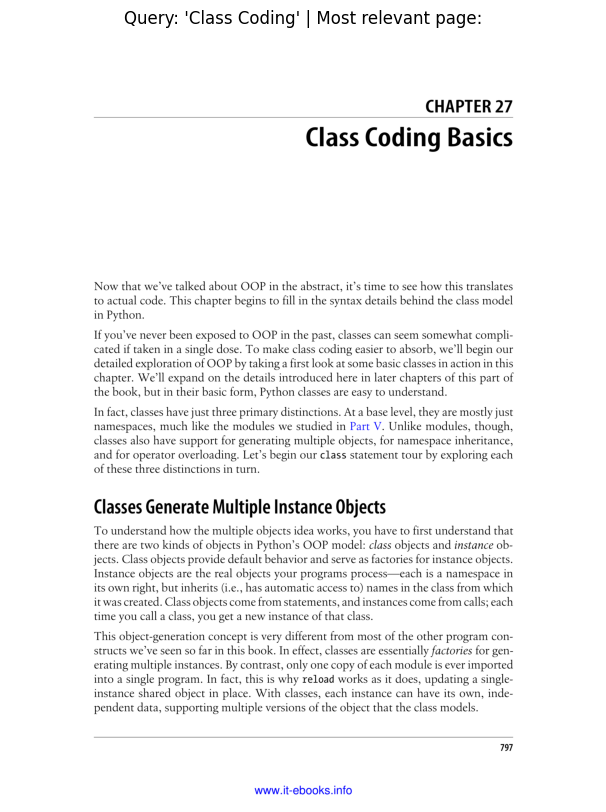

In [44]:
import fitz

# Open PDF and load target page
pdf_path = "Learning_Python.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(807 + 41) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, 
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

In [45]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


In [47]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [68]:
query = "class coding"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 2533 embeddings: 0.00005 seconds.


(tensor([0.6693, 0.6116, 0.6042, 0.5972, 0.5896], device='cuda:0'),
 tensor([1451, 1531, 2501, 1416,   19], device='cuda:0'))

In [69]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 2533 embeddings: 0.00005 seconds.
Query: class coding

Results:
Score: 0.6693
Chapter Summary This chapter introduced the basics of coding classes in Python.
We studied the syntax of the class statement, and we saw how to use it to build
up a class inheritance tree. We also studied how Python automatically fills in
the first argument in method func- tions, how attributes are attached to objects
in a class tree by simple assignment, and how specially named operator
overloading methods intercept and implement built-in operations for our
instances (e.g., expressions and printing). Now that we’ve learned all about the
mechanics of coding classes in Python, the next chapter turns to a larger and
more realistic example that ties together much of what we’ve learned about OOP
so far, and introduces some new topics. After that, we’ll continue our look at
class coding, taking a second pass over the model to fill in some of the details
that were omitted here to 

In [70]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 22 GB


In [85]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 22 | Recommend model: Gemma 7B in 4-bit or float16 precision.
use_quantization_config set to: False
model_id set to: google/gemma-7b-it


In [87]:
llm_model.to("cpu")  # Charger d'abord sur le CPU
# Puis déplacer seulement certaines parties du modèle sur le GPU comme nécessaire

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 3072, padding_idx=0)
    (layers): ModuleList(
      (0-27): 28 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (k_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (v_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=3072, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (up_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (down_proj): Linear(in_features=24576, out_features=3072, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): Gemma

In [88]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

8537680896

In [89]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 17142470656,
 'model_mem_mb': 16348.33,
 'model_mem_gb': 15.97}

In [96]:
input_text = "What is the Oriented object programming, and what's the main role of it?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What is the Oriented object programming, and what's the main role of it?

Prompt (formatted):
<bos><start_of_turn>user
What is the Oriented object programming, and what's the main role of it?<end_of_turn>
<start_of_turn>model



In [97]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cpu")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig 
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    603,    573, 182457,
           4018,  19991, 235269,    578,   1212, 235303, 235256,    573,   1872,
           4731,    576,    665, 235336,    107,    108,    106,   2516,    108]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]])}



Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    603,    573, 182457,
          4018,  19991, 235269,    578,   1212, 235303, 235256,    573,   1872,
          4731,    576,    665, 235336,    107,    108,    106,   2516,    108,
           688, 160578,   7614,  41424,    591, 212840,  77056,    109, 160578,
          7614,  41424,    591, 212840, 235275,    603,    476,  19991,  64180,
           674,   5377,   6815,   2177,   9113,    578,   8250, 235265,   1165,
           603,    476,  10276,   6815,   3505,  33609,    674,  71921, 199117,
          3966, 235269, 131855, 235269,    578,  72449, 235265,    109,    688,
          6377,  19912,    576, 173604,  66058,    109,    688, 235274, 235265,
        207195,   3966,  66058,    108, 212840,  46079, 199117,   3966,    731,
         73224,  14941,   1423,    578,   5358,   1280,   9113, 235269,    948,
           798,    614, 112375,    575,   6733,   8250,    578,   7340, 235265,
           109,  

In [1]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

NameError: name 'tokenizer' is not defined